# Gradient Boosted Survival Trees/Analysis

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [8]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))

dfp = df.to_pandas()
dfp_nn = dfp.dropna()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [29]:
X = dfp_nn.drop(columns=["time", "event"])
T = dfp_nn["time"].to_numpy()
E = dfp_nn["event"].to_numpy()
y = Surv.from_arrays(event=E.astype(bool), time=T)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

gbst = GradientBoostingSurvivalAnalysis(
    learning_rate=0.35,
    n_estimators=400,
    max_depth=2,
    min_samples_leaf=200,
    random_state=0,
    n_iter_no_change=20,
    verbose=2
)

start_time = time.time()
gbst.fit(X_train, y_train)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

      Iter       Train Loss   Remaining Time 
         1       78459.9127          473.26m
         2       78014.8554          453.62m
         3       77596.2916          446.71m
         4       77204.8145          443.59m
         5       76839.6266          440.93m
         6       76495.8313          438.74m
         7       76180.8033          436.66m
         8       75892.3572          435.25m
         9       75630.1461          433.45m
        10       75389.6887          432.03m
        11       75170.7648          430.55m
        12       74970.4227          429.13m
        13       74789.3771          427.75m
        14       74618.5310          426.47m
        15       74469.4750          425.27m
        16       74336.1380          423.97m
        17       74213.3608          422.95m
        18       74101.6780          421.75m
        19       73998.7091          421.25m
        20       73904.7222          421.16m
        21       73818.3694          421.33m
        2

In [30]:
c_index = concordance_index_censored(
    y_test["event"], y_test["time"], gbst.predict(X_test)
)[0]
print(f"C-index: {c_index:.4f}")

time_grid = np.arange(1,10)
pred_surv = gbst.predict_survival_function(X_test, return_array=True)
ibs = integrated_brier_score(y_test, y_test, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = ((y_test["event"] == True) & (y_test["time"] >= 2) & (y_test["time"] < 3)).astype(int)
p_interval = pred_surv[:, 2] - pred_surv[:, 3]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8701
Integrated Brier Score: 0.0412
Log loss for interval [2, 3): 0.0507


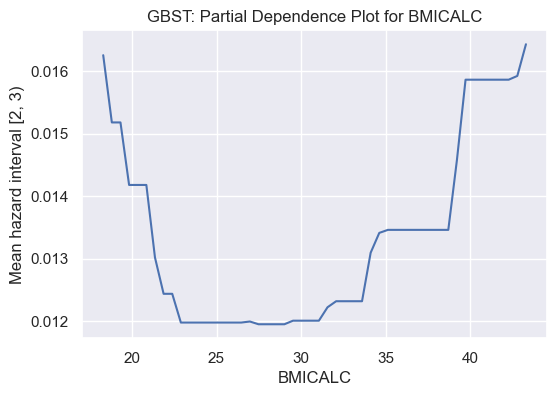

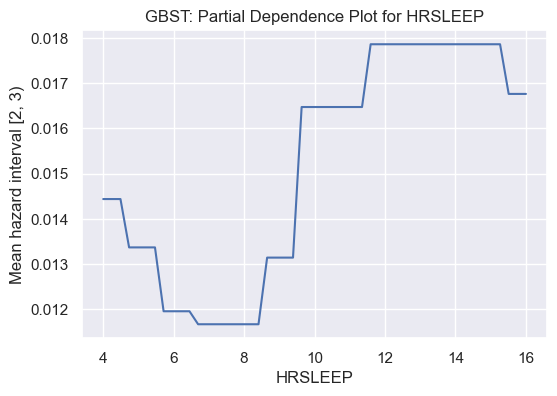

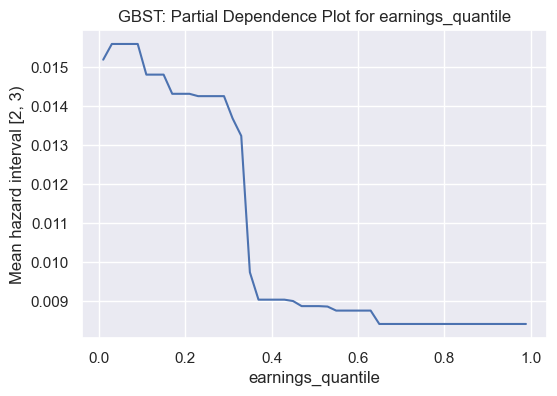

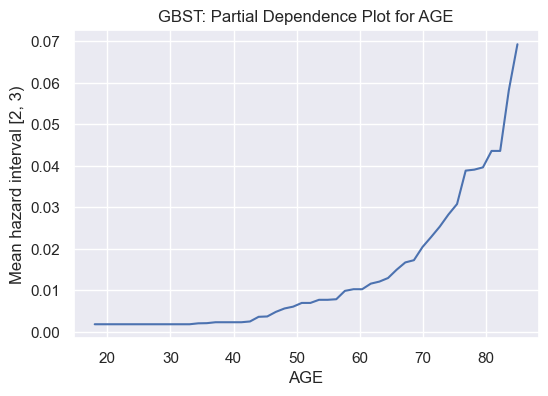

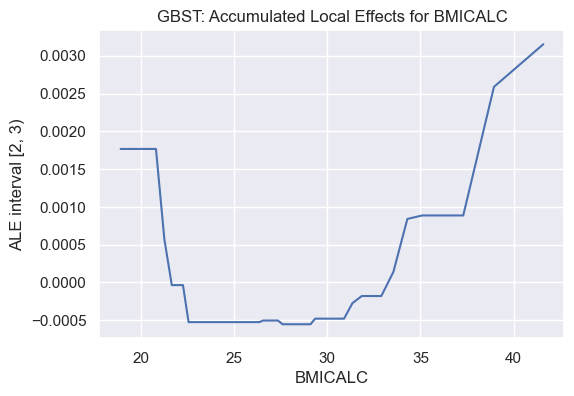

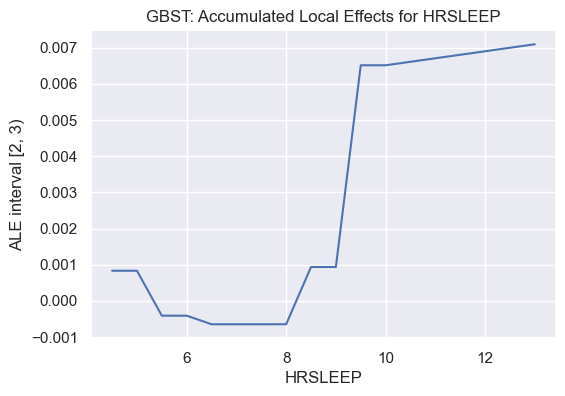

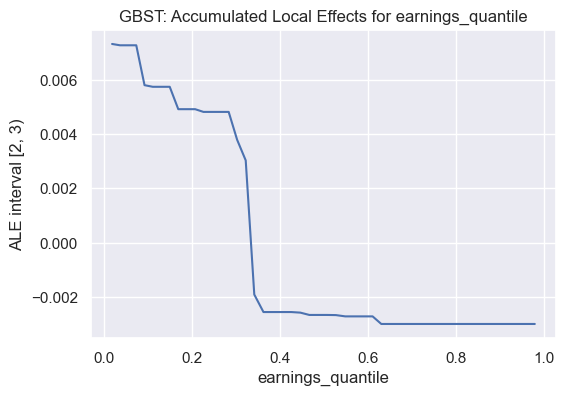

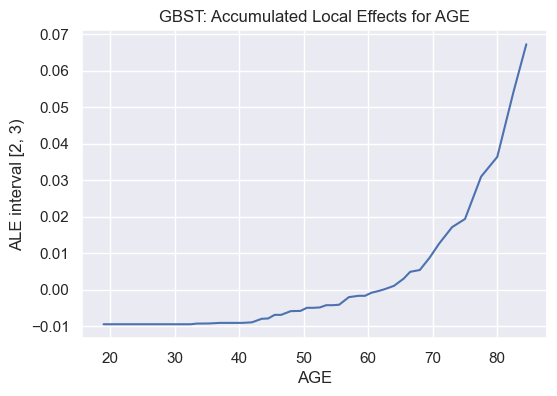

In [31]:
def plot_pdp(model, df, variable, t1, t2):
    x_vals = np.linspace(df[variable].quantile(0.01), df[variable].quantile(0.99), 50)
    y_vals = []
    for val in x_vals:
        df_copy = df.copy()
        df_copy[variable] = val
        pred_surv = model.predict_survival_function(df_copy, return_array=True)
        y_vals.append((pred_surv[:,t1] - pred_surv[:,t2]).mean())
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"GBST: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, df, variable, t1, t2):
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper

        pred_surv_high = model.predict_survival_function(df_high, return_array=True)
        pred_surv_low = model.predict_survival_function(df_low, return_array=True)
        pred_diff = (pred_surv_high[:,t1] - pred_surv_high[:,t2]) - (pred_surv_low[:,t1] - pred_surv_low[:,t2])
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"GBST: Accumulated Local Effects for {variable}")
    plt.show()

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_pdp(gbst, X_test, var, 2, 3)

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_ale(gbst, X_test, var, 2, 3)

In [3]:
D2 = pd.read_csv("data/D2.csv")
X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
T_D2 = D2["T"].to_numpy()
E_D2 = D2["event"].to_numpy()
mu_D2 = D2["mu"].to_numpy()
T_D2 = np.floor(T_D2)

y_D2 = Surv.from_arrays(event=E_D2.astype(bool), time=T_D2)
X_D2_train, X_D2_test, y_D2_train, y_D2_test, _, mu_D2_test = train_test_split(X_D2, y_D2, mu_D2, test_size=0.2, random_state=0)
X_D2_train, _, y_D2_train, _ = train_test_split(X_D2_train, y_D2_train, test_size=0.9, random_state=0)

gbst_D2 = GradientBoostingSurvivalAnalysis(
    learning_rate=0.6,
    n_estimators=300,
    max_depth=2,
    min_samples_leaf=200,
    random_state=0,
    n_iter_no_change=20,
    verbose=2
)

start_time = time.time()
gbst_D2.fit(X_D2_train, y_D2_train)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

      Iter       Train Loss   Remaining Time 
         1      117579.8193          525.35m
         2      115892.7821          512.35m
         3      114381.7853          492.14m
         4      113130.8898          481.37m
         5      112109.1798          474.92m
         6      111176.0384          470.29m
         7      110384.5289          466.95m
         8      109755.0159          465.44m
         9      109205.6850          464.24m
        10      108770.8507          461.68m
        11      108402.9998          458.75m
        12      108102.3123          457.56m
        13      107841.7468          457.68m
        14      107617.1804          457.49m
        15      107433.1839          459.61m
        16      107267.4249          461.84m
        17      107116.5185          463.53m
        18      106976.2320          464.77m
        19      106848.4773          465.43m
        20      106734.2799          465.72m
        21      106628.7639          466.01m
        2

In [4]:
c_index = concordance_index_censored(
    y_D2_test["event"], y_D2_test["time"], gbst_D2.predict(X_D2_test)
)[0]
print(f"C-index: {c_index:.4f}")

time_grid = np.arange(1,10)
pred_surv = gbst_D2.predict_survival_function(X_D2_test, return_array=True)

ibs = integrated_brier_score(y_D2_test, y_D2_test, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = (y_D2_test["event"]).astype(int)
p_interval = 1 - pred_surv[:, -1]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9031
Integrated Brier Score: 0.0364
Log loss for interval [0, 10): 0.1886


In [5]:
events = (y_D2_test["event"]).astype(int)
pred = np.minimum(1-1e-5, np.maximum(1e-5, 1 - pred_surv[:, -1]))
mse = np.mean(np.square(np.log(mu_D2_test) - np.log(pred)))
dev = -2*np.sum(events*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[events==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.5916
Logistic deviance:           103817
Kullback-Leibler divergence: 34029


Text(0, 0.5, 'Predicted log mortality')

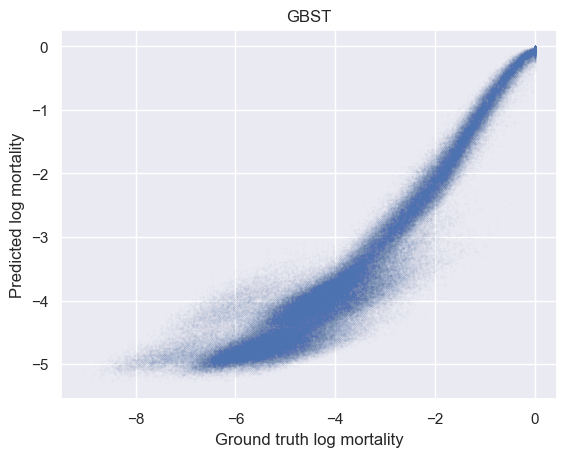

In [6]:
plt.plot(np.log(mu_D2_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("GBST")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")

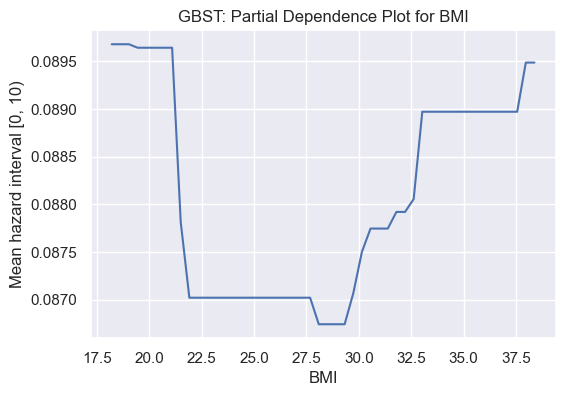

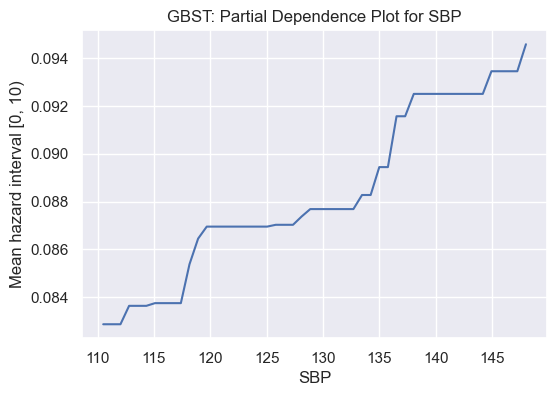

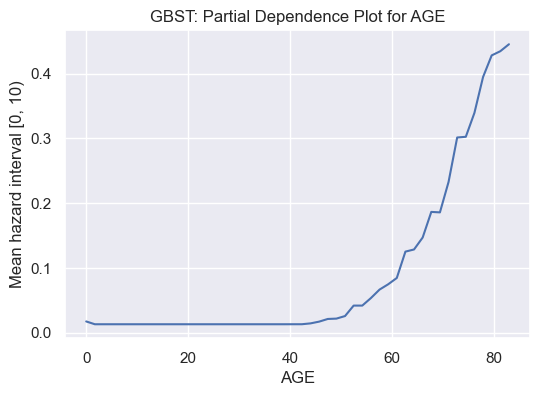

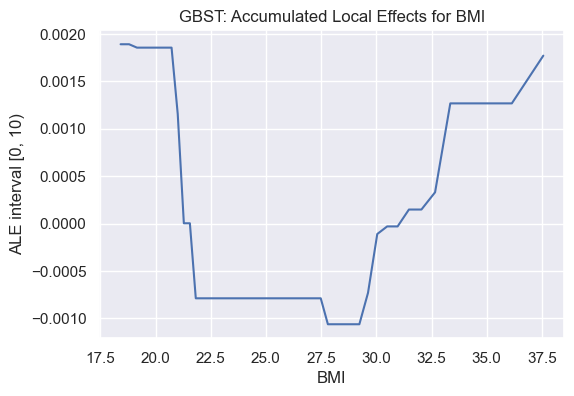

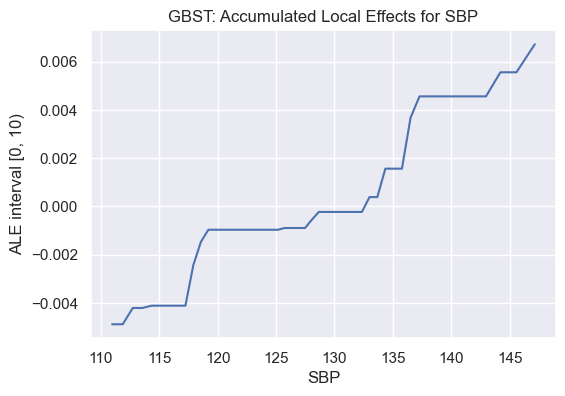

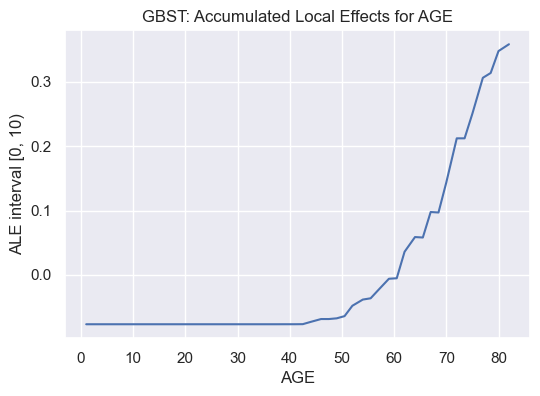

In [7]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(gbst_D2, X_D2_test, var, 0, 10)

for var in ["BMI", "SBP", "AGE"]:
    plot_ale(gbst_D2, X_D2_test, var, 0, 10)